<h2 style="color: teal">Customer Churn Prediction<a class="tocSkip"></a></h2>
    
The telecommunications operator wants to learn how to predict customer churn. If it appears that a user plans to leave, they will be offered promotional codes and special conditions. The operator's team has collected personal data about some customers, as well as information about their tariffs and contracts.

**My task** is to analyze the customers data and their behavior in order to better understand their needs and adapt the services and products of the telecommunications operator accordingly.

**The project's goal** is to build a model for predicting the probability of customer churn. The evaluation criterion for the model will be the MAE (Mean Absolute Error) metric, and the AUC-ROC value should be at least 0.88.

**Research Process**.

The research will be conducted in 4 stages:
 
 1. Data Exploration
 2. Data Preprocessing
 3. Model Training
 4. Analysis Report
    
<img src="https://data-science-blog.com/wp-content/uploads/2017/08/future-of-crm-header.png" width="900" height="800" alt="Future of CRM (c) data-science-blog.com" />

# Data Description

* **BeginDate:** Service start date.
* **EndDate:** Service end date.
* **Type:** Payment type (monthly, yearly).
* **Dependents:** Presence of dependents.
* **SeniorCitizen:** Presence of senior citizen status by age.
* **Partner:** Presence of a partner.
* **InternetService, OnlineSecurity, OnlineBackup, DeviceProtection, TechSupport, StreamingTV, and StreamingMovies:** Additional internet services.
* **MultipleLines:** Presence of multiple lines during a call.

# Data Preparation

The necessary libraries and data files should be loaded first.

In [1]:
# !pip install phik
# !pip install scikit-learn --upgrade

In [2]:
# Library loading

import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

import phik

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import confusion_matrix, roc_curve, precision_score, recall_score, roc_auc_score, \
ConfusionMatrixDisplay
from sklearn.utils.class_weight import compute_class_weight
from phik.report import plot_correlation_matrix

import warnings
warnings.filterwarnings("ignore")

In [3]:
# Parameter setup

sns.set_style("darkgrid")
RANDOM_STATE = 30323

In [4]:
# File reading

df_contract = pd.read_csv("./contract.csv", index_col='customerID')
df_personal = pd.read_csv("./personal.csv", index_col='customerID')
df_internet = pd.read_csv("./internet.csv", index_col='customerID')
df_phone = pd.read_csv("./phone.csv", index_col='customerID')

Next follow the functions that I will use in the analysis.

In [5]:
# Function for exploring each dataframe

def general_info(df):
    display(df.head())
    display(df.describe())
    df.info()
    
# Function for displaying ROC curve for each model
    
def plot_roc_curve(target_test, predicted_probalities):
    fpr, tpr, thresholds = roc_curve(target_test, predicted_probalities)
    plt.figure(figsize=(7,7))
    plt.plot(fpr, tpr, color='g')
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', alpha=.8)
    plt.xlim([0.0,1.0])
    plt.ylim([0.0,1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Model ROC Curve')
    plt.legend(["ROC Curve", "Random Curve"], loc=2)
    plt.show()

Now we can proceed to the data exploration stage.

# Data Exploration

## Contract Information

General information about the dataset:

In [6]:
# Call the function for df_contract

general_info(df_contract)

,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
customerID,,,,,,,
7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65


,MonthlyCharges
count,7043.000000
mean,64.761692
std,30.090047
min,18.250000
25%,35.500000
50%,70.350000
75%,89.850000
max,118.750000


<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   BeginDate         7043 non-null   object 
 1   EndDate           7043 non-null   object 
 2   Type              7043 non-null   object 
 3   PaperlessBilling  7043 non-null   object 
 4   PaymentMethod     7043 non-null   object 
 5   MonthlyCharges    7043 non-null   float64
 6   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(6)
memory usage: 440.2+ KB


Let's look at the distribution of data in the **numerical feature.**

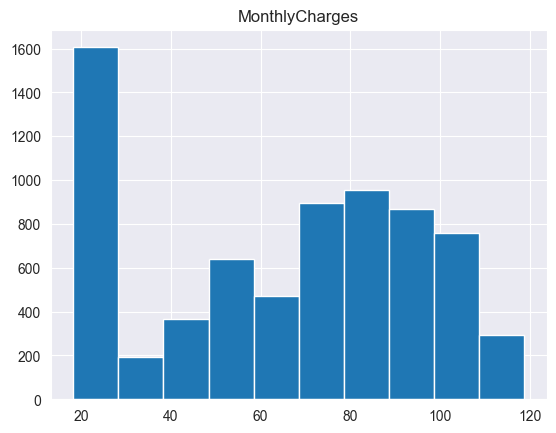

In [7]:
# Display histogram for the feature distribution

df_contract.hist();

Let's see how the data is distributed in **categorical features.**

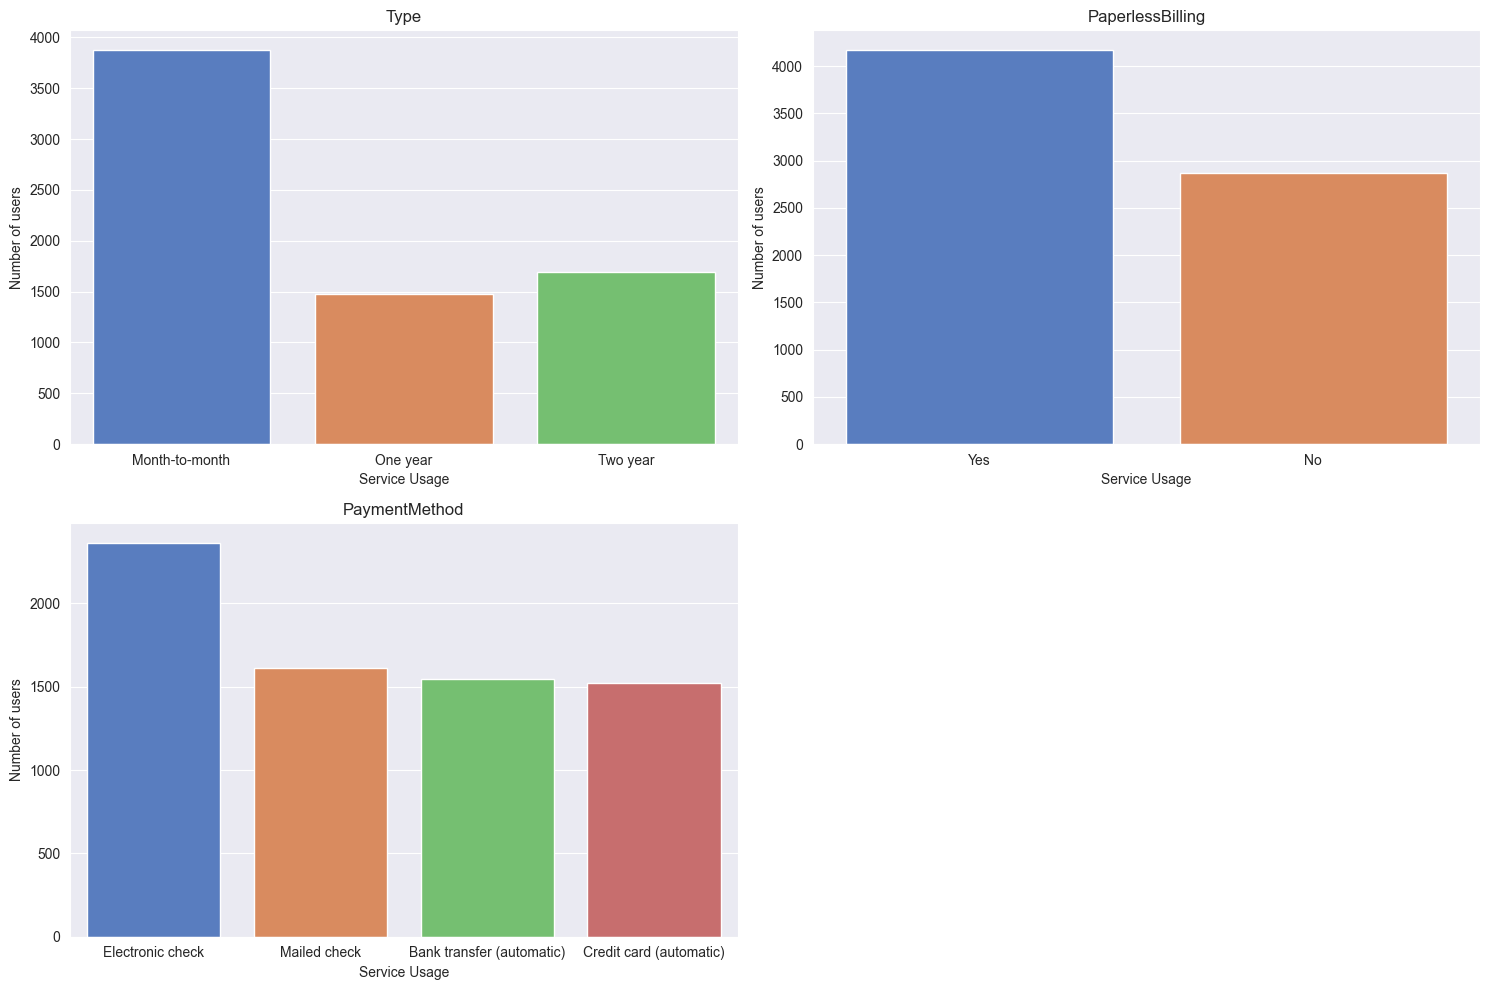

In [8]:
# Save categorical columns in a separate variable

categorical = df_contract[['Type', 'PaperlessBilling', 'PaymentMethod']]
plt.figure(figsize=(15, 10))

# Iterate over each categorical column using a loop

for i, col in enumerate(categorical):
    ax = plt.subplot(2, 2, i+1)
    
    # Create a count plot for the categorical column
    
    sns.countplot(data=df_contract, x=col, ax=ax, palette='muted')
    ax.set_title(col)
    ax.set_xlabel('Service Usage')
    ax.set_ylabel('Number of users')

# Increase the horizontal spacing between the plots

plt.subplots_adjust(wspace=0.5)

plt.tight_layout()

**Conclusion.**
* The dataset contains 7043 observations and 8 features. The features `BeginDate`, `EndDate`, and `TotalCharges` have incorrect data types, and there are no missing values. Based on the `EndDate` column (contract end date), we can create the target feature: an open date (value in the feature is "No") means that the contract is active and the user continues to use the services; a date reflected in the feature means that the client has churned.
* The `MonthlyCharges` feature has a wide range of data, as observed from the histogram and the standard deviation (std) value.
* Most customers pay for services on a monthly basis, while approximately half as many customers opt for a 1-2 year contract.
* Most customers use paperless billing.
* The most popular payment method is electronic check, followed by almost equal use of mailed check and automatic payment methods.

## Customer Personal Data

General information about the dataset:

In [9]:
# Call the function for df_personal

general_info(df_personal)

,gender,SeniorCitizen,Partner,Dependents
customerID,,,,
7590-VHVEG,Female,0,Yes,No
5575-GNVDE,Male,0,No,No
3668-QPYBK,Male,0,No,No
7795-CFOCW,Male,0,No,No
9237-HQITU,Female,0,No,No


,SeniorCitizen
count,7043.000000
mean,0.162147
std,0.368612
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   gender         7043 non-null   object
 1   SeniorCitizen  7043 non-null   int64 
 2   Partner        7043 non-null   object
 3   Dependents     7043 non-null   object
dtypes: int64(1), object(3)
memory usage: 275.1+ KB


Distribution of data in the **numerical feature:**

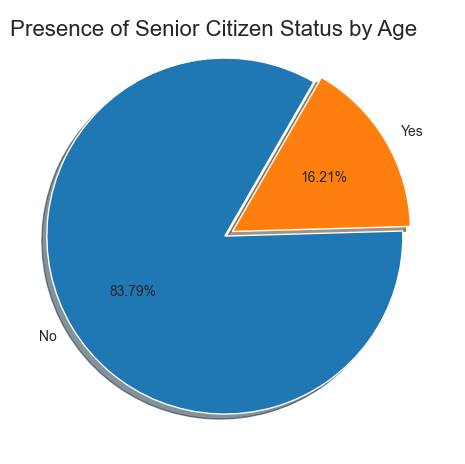

In [10]:
# Display a pie chart of the data distribution

plt.figure(figsize=(15, 5))
plt.pie(df_personal['SeniorCitizen'].value_counts(),
            labels=['No', 'Yes'],
            autopct='%1.2f%%',
            shadow=True,
            explode=(0.05, 0),
            startangle=60)
plt.suptitle('Presence of Senior Citizen Status by Age', fontsize=16)
plt.subplots_adjust(top=1)
plt.show()

Distribution of data in **categorical features:**

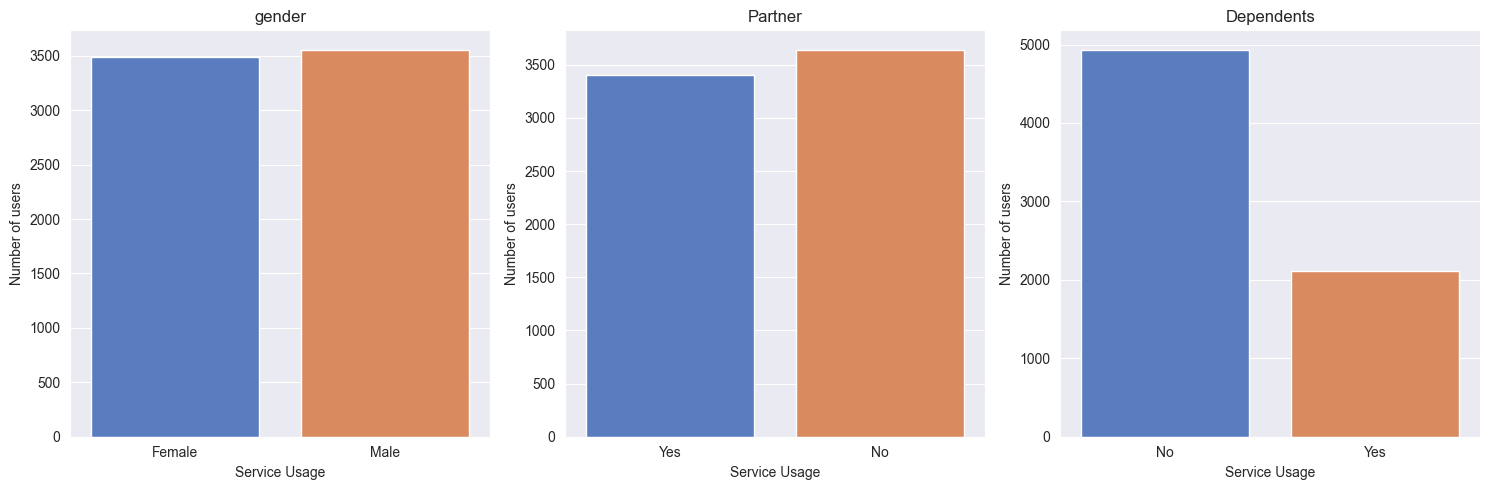

In [11]:
categorical = df_personal.select_dtypes('object').columns
plt.figure(figsize=(15, 5))

for i, col in enumerate(categorical):
    ax = plt.subplot(1, 3, i+1)
    sns.countplot(data=df_personal, x=col, ax=ax, palette='muted')
    ax.set_title(col)
    ax.set_xlabel('Service Usage')
    ax.set_ylabel('Number of users')
plt.tight_layout()

**Conclusion:**
* The dataset containing customer information has a total of 7043 observations (data is available for all customers) and 5 features (with correct data types and no missing values).
* The number of customers who have not reached retirement age is 5 times higher than the number of retirees.
* The number of male and female customers is approximately equal.
* There are slightly more unmarried customers than married ones.
* The number of customers without dependents is 2.5 times higher compared to those who have dependents.

## Internet Service Information

General information about the dataset:

In [12]:
# Call the function for df_internet

general_info(df_internet)

,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
customerID,,,,,,,
7590-VHVEG,DSL,No,Yes,No,No,No,No
5575-GNVDE,DSL,Yes,No,Yes,No,No,No
3668-QPYBK,DSL,Yes,Yes,No,No,No,No
7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
9237-HQITU,Fiber optic,No,No,No,No,No,No


,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
count,5517,5517,5517,5517,5517,5517,5517
unique,2,2,2,2,2,2,2
top,Fiber optic,No,No,No,No,No,No
freq,3096,3498,3088,3095,3473,2810,2785


<class 'pandas.core.frame.DataFrame'>
Index: 5517 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   InternetService   5517 non-null   object
 1   OnlineSecurity    5517 non-null   object
 2   OnlineBackup      5517 non-null   object
 3   DeviceProtection  5517 non-null   object
 4   TechSupport       5517 non-null   object
 5   StreamingTV       5517 non-null   object
 6   StreamingMovies   5517 non-null   object
dtypes: object(7)
memory usage: 344.8+ KB


All features are categorical. Distribution of data in the features:

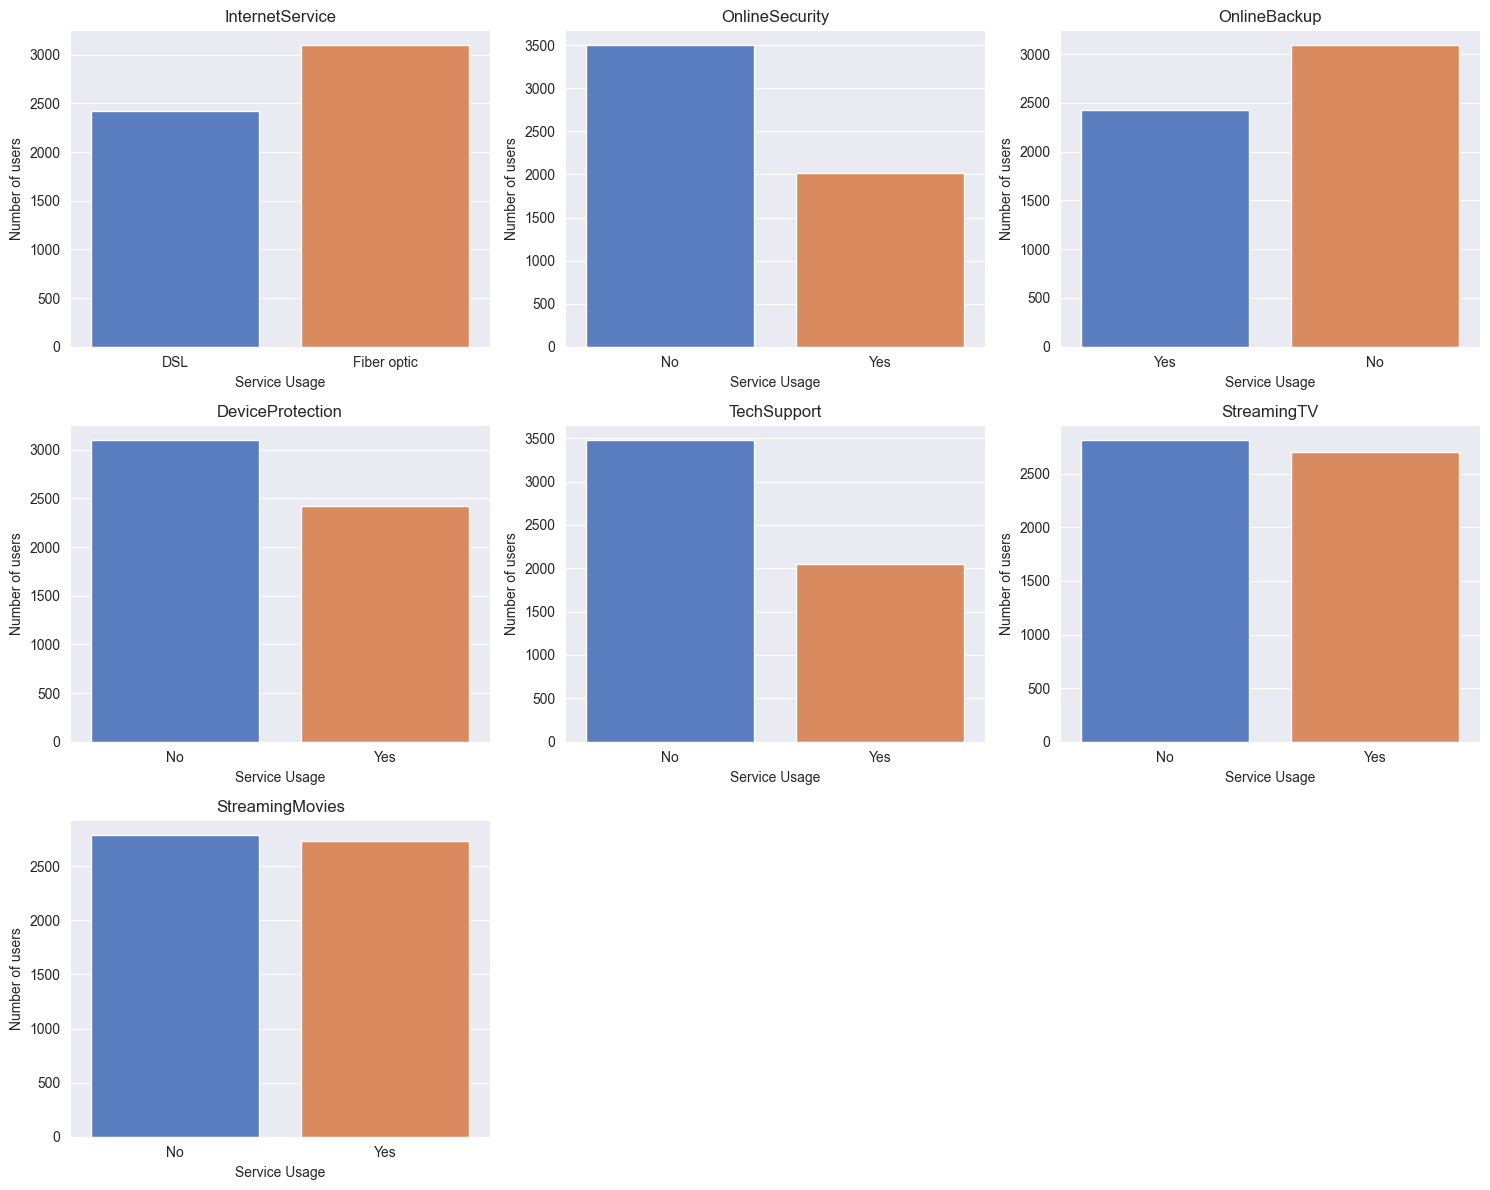

In [13]:
categorical = df_internet.select_dtypes('object').columns
plt.figure(figsize=(15, 12))

for i, col in enumerate(categorical):
    ax = plt.subplot(3, 3, i+1)
    sns.countplot(data=df_internet, x=col, ax=ax, palette='muted')
    ax.set_title(col)
    ax.set_xlabel('Service Usage')
    ax.set_ylabel('Number of users')
plt.tight_layout()

**Conclusion:**
* The dataset containing information about internet services has a total of 5517 observations (data is not available for all customers) and 8 features (with correct data types and no missing values).
* There are more users of fiber optic internet compared to DSL.
* Additional services such as online security, online backup, device protection, and tech support are generally not popular among customers.
* The number of customers not using streaming services is slightly higher than those using them. However, it should be noted that the data is not available for all customers, and it can be assumed that the absence of data indicates that customers do not use those services. In this case, it can be concluded that additional services are not particularly popular among users in general.

## Phone Service Information

General information about the dataset:

In [14]:
# Call the function for df_phone

general_info(df_phone)

,MultipleLines
customerID,
5575-GNVDE,No
3668-QPYBK,No
9237-HQITU,No
9305-CDSKC,Yes
1452-KIOVK,Yes


,MultipleLines
count,6361
unique,2
top,No
freq,3390


<class 'pandas.core.frame.DataFrame'>
Index: 6361 entries, 5575-GNVDE to 3186-AJIEK
Data columns (total 1 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   MultipleLines  6361 non-null   object
dtypes: object(1)
memory usage: 99.4+ KB


Distribution of data in the dataset:

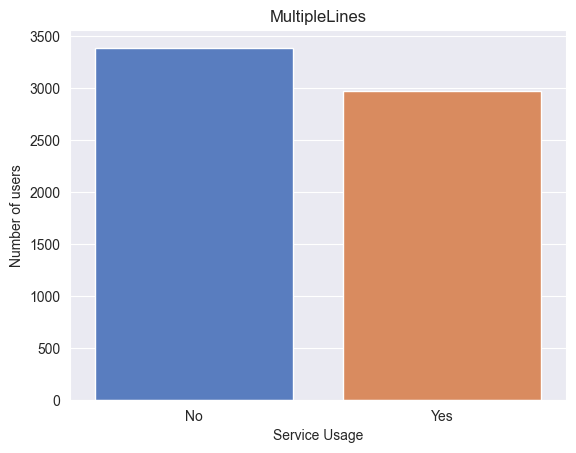

In [15]:
# Plot and display the histogram of data distribution in the categorical feature

sns.countplot(data=df_phone, x='MultipleLines', palette='muted')
plt.title('MultipleLines')
plt.xlabel('Service Usage')
plt.ylabel('Number of users')
plt.show()

**Conclusion:** 

* The dataset containing information about phone services has a total of 6361 observations (data is not available for all customers) and 1 feature (with correct data type and no missing values). Based on the graph, it can be observed that most people do not use phone services with multiple lines.

The data has been explored, and we can proceed to the planning stage of further work.

# Work Plan

1. Data preprocessing: converting data to the correct data type, handling missing values.
2. Combining datasets and exploring the sample to determine its main characteristics and relationships between features.
3. Creating new synthetic features: target feature, feature indicating the duration of service usage, feature indicating the number of services used by the customer (internet, phone, TV).
4. Checking for multicollinearity between features.
5. Exploring models with hyperparameter tuning.
6. Evaluation of the quality of the best model on the test set.
7. Assessing the quality of the best model using additional metrics such as recall and precision.
8. Analysing the importance of features.
9. Preparing a report summarizing the conducted work.

# Data Preprocessing

First, I will create the target feature based on the `EndDate` column.

In [16]:
# Add a column CancelFactor with default values of 0

df_contract['CancelFactor'] = 0

# Replace values in CancelFactor column for churned customers

df_contract.loc[df_contract['EndDate'] != 'No', 'CancelFactor'] = 1

Next, I will replace the 'No' value in the `EndDate` column with the data extraction date - February 1, 2020 (without this replacement, we won't be able to convert the column type and use it for further analysis).

In [17]:
df_contract['EndDate'] = df_contract['EndDate'].replace(['No'], ['2020-02-01'])

Checking the results of the performed transformations:

In [18]:
df_contract.head()

,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,CancelFactor
customerID,,,,,,,,
7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,29.85,0
5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,1889.5,0
3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,1
7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,1840.75,0
9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65,1


### Data Type Transformation

It was previously discovered that the data types of the features `BeginDate`, `EndDate`, and `TotalCharges` have incorrect format. I will transform them now.

In [19]:
# transforming the data type in the date columns using the to_datetime() method

df_contract['BeginDate'] = pd.to_datetime(df_contract['BeginDate'], format='%Y-%m-%d')
df_contract['EndDate'] = pd.to_datetime(df_contract['EndDate'], format='%Y-%m-%d')

# changing the data type of the TotalCharges column to float using pd.to_numeric()

df_contract['TotalCharges'] = pd.to_numeric(df_contract['TotalCharges'], errors='coerce')

Let's see the result of the transformation:

In [20]:
df_contract.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   BeginDate         7043 non-null   datetime64[ns]
 1   EndDate           7043 non-null   datetime64[ns]
 2   Type              7043 non-null   object        
 3   PaperlessBilling  7043 non-null   object        
 4   PaymentMethod     7043 non-null   object        
 5   MonthlyCharges    7043 non-null   float64       
 6   TotalCharges      7032 non-null   float64       
 7   CancelFactor      7043 non-null   int64         
dtypes: datetime64[ns](2), float64(2), int64(1), object(3)
memory usage: 753.2+ KB


Now the data has the correct data type, but there are missing values in the `TotalCharges` column. To understand how to handle these missing values, let's examine the table with empty values in this column.

### Handling Missing Values

In [21]:
# displaying the table with missing values in the TotalCharges column using the isna() method

df_contract[df_contract['TotalCharges'].isna()]

,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,CancelFactor
customerID,,,,,,,,
4472-LVYGI,2020-02-01,2020-02-01,Two year,Yes,Bank transfer (automatic),52.55,NaN,0
3115-CZMZD,2020-02-01,2020-02-01,Two year,No,Mailed check,20.25,NaN,0
5709-LVOEQ,2020-02-01,2020-02-01,Two year,No,Mailed check,80.85,NaN,0
4367-NUYAO,2020-02-01,2020-02-01,Two year,No,Mailed check,25.75,NaN,0
1371-DWPAZ,2020-02-01,2020-02-01,Two year,No,Credit card (automatic),56.05,NaN,0
7644-OMVMY,2020-02-01,2020-02-01,Two year,No,Mailed check,19.85,NaN,0
3213-VVOLG,2020-02-01,2020-02-01,Two year,No,Mailed check,25.35,NaN,0
2520-SGTTA,2020-02-01,2020-02-01,Two year,No,Mailed check,20.00,NaN,0
2923-ARZLG,2020-02-01,2020-02-01,One year,Yes,Mailed check,19.70,NaN,0


Based on the data, the missing values in the `TotalCharges` column are present for customers whose contract started on the data extraction date, indicating that no payments have been made yet. Therefore, it is possible to fill the missing values with zero.

In [22]:
# replacing missing values using the fillna() method

df_contract['TotalCharges'] = df_contract['TotalCharges'].fillna(0)

I also check if there are any remaining missing values in the column:

In [23]:
# counting the number of missing values

df_contract['TotalCharges'].isna().sum()

0

The `df_contract` dataset has been transformed, and now we can combine all the available samples into one dataframe and continue with exploratory analysis.

### Data Integration

In [24]:
df_telecom = df_contract.join([df_personal, df_internet, df_phone])

In [25]:
# calling a function to display general information about the new dataset

general_info(df_telecom)

,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,CancelFactor,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
customerID,,,,,,,,,,,,,,,,,,,,
7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,29.85,0,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,NaN
5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,1889.50,0,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No
3668-QPYBK,2019-10-01,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15,1,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No
7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,1840.75,0,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,NaN
9237-HQITU,2019-09-01,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65,1,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No


,MonthlyCharges,TotalCharges,CancelFactor,SeniorCitizen
count,7043.000000,7043.000000,7043.000000,7043.000000
mean,64.761692,2279.734304,0.265370,0.162147
std,30.090047,2266.794470,0.441561,0.368612
min,18.250000,0.000000,0.000000,0.000000
25%,35.500000,398.550000,0.000000,0.000000
50%,70.350000,1394.550000,0.000000,0.000000
75%,89.850000,3786.600000,1.000000,0.000000
max,118.750000,8684.800000,1.000000,1.000000


<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   BeginDate         7043 non-null   datetime64[ns]
 1   EndDate           7043 non-null   datetime64[ns]
 2   Type              7043 non-null   object        
 3   PaperlessBilling  7043 non-null   object        
 4   PaymentMethod     7043 non-null   object        
 5   MonthlyCharges    7043 non-null   float64       
 6   TotalCharges      7043 non-null   float64       
 7   CancelFactor      7043 non-null   int64         
 8   gender            7043 non-null   object        
 9   SeniorCitizen     7043 non-null   int64         
 10  Partner           7043 non-null   object        
 11  Dependents        7043 non-null   object        
 12  InternetService   5517 non-null   object        
 13  OnlineSecurity    5517 non-null   object        
 14  OnlineBackup  

There are missing values in the features related to the use of internet services and telephony, namely: `InternetService`, `OnlineSecurity`, `OnlineBackup`, `DeviceProtection`, `TechSupport`, `StreamingTV`, `StreamingMovies`, `MultipleLines`. Most likely, this is because the customers do not use these services. Thus, the missing values can be filled with 'No', except for the `MultipleLines` feature - it will be filled with 'None' (in this column, 'No' denotes a single line type, not the absence of a service).

In [26]:
# saving features with missing values in a separate variable

missing_values = df_telecom[['InternetService', 'OnlineSecurity', 'OnlineBackup', \
                             'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']]

In [27]:
# using a loop to iterate through the feature values and fill in the missing values

for i in missing_values:
    df_telecom[i] = df_telecom[i].fillna('No')

In [28]:
# filling missing values in the MultipleLines feature

df_telecom['MultipleLines'] = df_telecom['MultipleLines'].fillna('None')

Checking for the presence of missing values:

In [29]:
df_telecom.isna().sum().sum()

0

Checking the unique values in `MultipleLines` after filling the missing values:

In [30]:
df_telecom['MultipleLines'].unique()

array(['None', 'No', 'Yes'], dtype=object)

There are no missing values in the data.

### Duplicate Checking

Displaying the count of explicit duplicates in the sample:

In [31]:
df_telecom.duplicated().sum()

13

Displaying the rows that are duplicates:

In [32]:
df_telecom[df_telecom.duplicated() == True]

,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,CancelFactor,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
customerID,,,,,,,,,,,,,,,,,,,,
8605-ITULD,2020-01-01,2020-02-01,Month-to-month,No,Mailed check,19.55,19.55,0,Female,0,No,No,No,No,No,No,No,No,No,No
3247-MHJKM,2020-01-01,2020-02-01,Month-to-month,No,Mailed check,20.20,20.20,0,Male,0,No,No,No,No,No,No,No,No,No,No
5996-DAOQL,2020-01-01,2020-02-01,Month-to-month,Yes,Mailed check,20.45,20.45,0,Male,0,No,No,No,No,No,No,No,No,No,No
2668-TZSPS,2020-01-01,2020-02-01,Month-to-month,No,Mailed check,20.45,20.45,0,Male,0,No,No,No,No,No,No,No,No,No,No
2636-ALXXZ,2019-12-01,2020-01-01,Month-to-month,Yes,Electronic check,69.60,69.60,1,Female,1,No,No,Fiber optic,No,No,No,No,No,No,No
7096-UCLNH,2020-01-01,2020-02-01,Month-to-month,No,Mailed check,20.05,20.05,0,Male,0,No,No,No,No,No,No,No,No,No,No
8048-DSDFQ,2020-01-01,2020-02-01,Month-to-month,No,Mailed check,20.20,20.20,0,Male,0,No,No,No,No,No,No,No,No,No,No
8749-CLJXC,2020-01-01,2020-02-01,Month-to-month,No,Mailed check,20.05,20.05,0,Male,0,No,No,No,No,No,No,No,No,No,No
2676-ISHSF,2020-01-01,2020-02-01,Month-to-month,No,Mailed check,20.30,20.30,0,Male,0,No,No,No,No,No,No,No,No,No,No


For comparison I will also display all duplicates, including the original rows:

In [33]:
df_telecom[df_telecom.duplicated(keep=False)]

,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,CancelFactor,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
customerID,,,,,,,,,,,,,,,,,,,,
6380-ARCEH,2020-01-01,2020-02-01,Month-to-month,No,Mailed check,20.20,20.20,0,Male,0,No,No,No,No,No,No,No,No,No,No
2866-IKBTM,2020-01-01,2020-02-01,Month-to-month,No,Mailed check,19.55,19.55,0,Female,0,No,No,No,No,No,No,No,No,No,No
3030-ZKIWL,2020-01-01,2020-02-01,Month-to-month,No,Mailed check,20.05,20.05,0,Male,0,No,No,No,No,No,No,No,No,No,No
8262-COGGB,2020-01-01,2020-02-01,Month-to-month,Yes,Mailed check,20.45,20.45,0,Male,0,No,No,No,No,No,No,No,No,No,No
8605-ITULD,2020-01-01,2020-02-01,Month-to-month,No,Mailed check,19.55,19.55,0,Female,0,No,No,No,No,No,No,No,No,No,No
8375-DKEBR,2019-12-01,2020-01-01,Month-to-month,Yes,Electronic check,69.60,69.60,1,Female,1,No,No,Fiber optic,No,No,No,No,No,No,No
3247-MHJKM,2020-01-01,2020-02-01,Month-to-month,No,Mailed check,20.20,20.20,0,Male,0,No,No,No,No,No,No,No,No,No,No
0673-IGUQO,2020-01-01,2020-02-01,Month-to-month,No,Mailed check,20.45,20.45,0,Male,0,No,No,No,No,No,No,No,No,No,No
5996-DAOQL,2020-01-01,2020-02-01,Month-to-month,Yes,Mailed check,20.45,20.45,0,Male,0,No,No,No,No,No,No,No,No,No,No


Duplicates have been identified as rows with identical data for different users. There are no fully duplicated rows in the data based on the absence of duplicating customerIDs.

### Creating Synthetic Features

Feature representing the duration of service usage:

In [34]:
df_telecom['UsageTime'] = (df_telecom['EndDate'] - df_telecom['BeginDate']).dt.days

Feature with the count of services used by the client (internet, phone, television):

In [35]:
# creating a list of features in which we need to count the number of 'Yes' values

cols = ['InternetService', 'OnlineSecurity', 'OnlineBackup',
        'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'MultipleLines']

# creating a new feature indicating the count of features with 'Yes' values

df_telecom['NumberOfServices'] = df_telecom[cols].apply(lambda x: x.str.count('Yes').sum(), axis=1)

Performing a check:

In [36]:
df_telecom.head()

,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,CancelFactor,gender,SeniorCitizen,...,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,UsageTime,NumberOfServices
customerID,,,,,,,,,,,,,,,,,,,,,
7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,29.85,0,Female,0,...,DSL,No,Yes,No,No,No,No,None,31,1
5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,1889.50,0,Male,0,...,DSL,Yes,No,Yes,No,No,No,No,1036,2
3668-QPYBK,2019-10-01,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15,1,Male,0,...,DSL,Yes,Yes,No,No,No,No,No,61,2
7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,1840.75,0,Male,0,...,DSL,Yes,No,Yes,Yes,No,No,None,1371,3
9237-HQITU,2019-09-01,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65,1,Female,0,...,Fiber optic,No,No,No,No,No,No,No,61,0


### Analysis of Feature Distribution with Respect to the Target Feature

For categorical features:

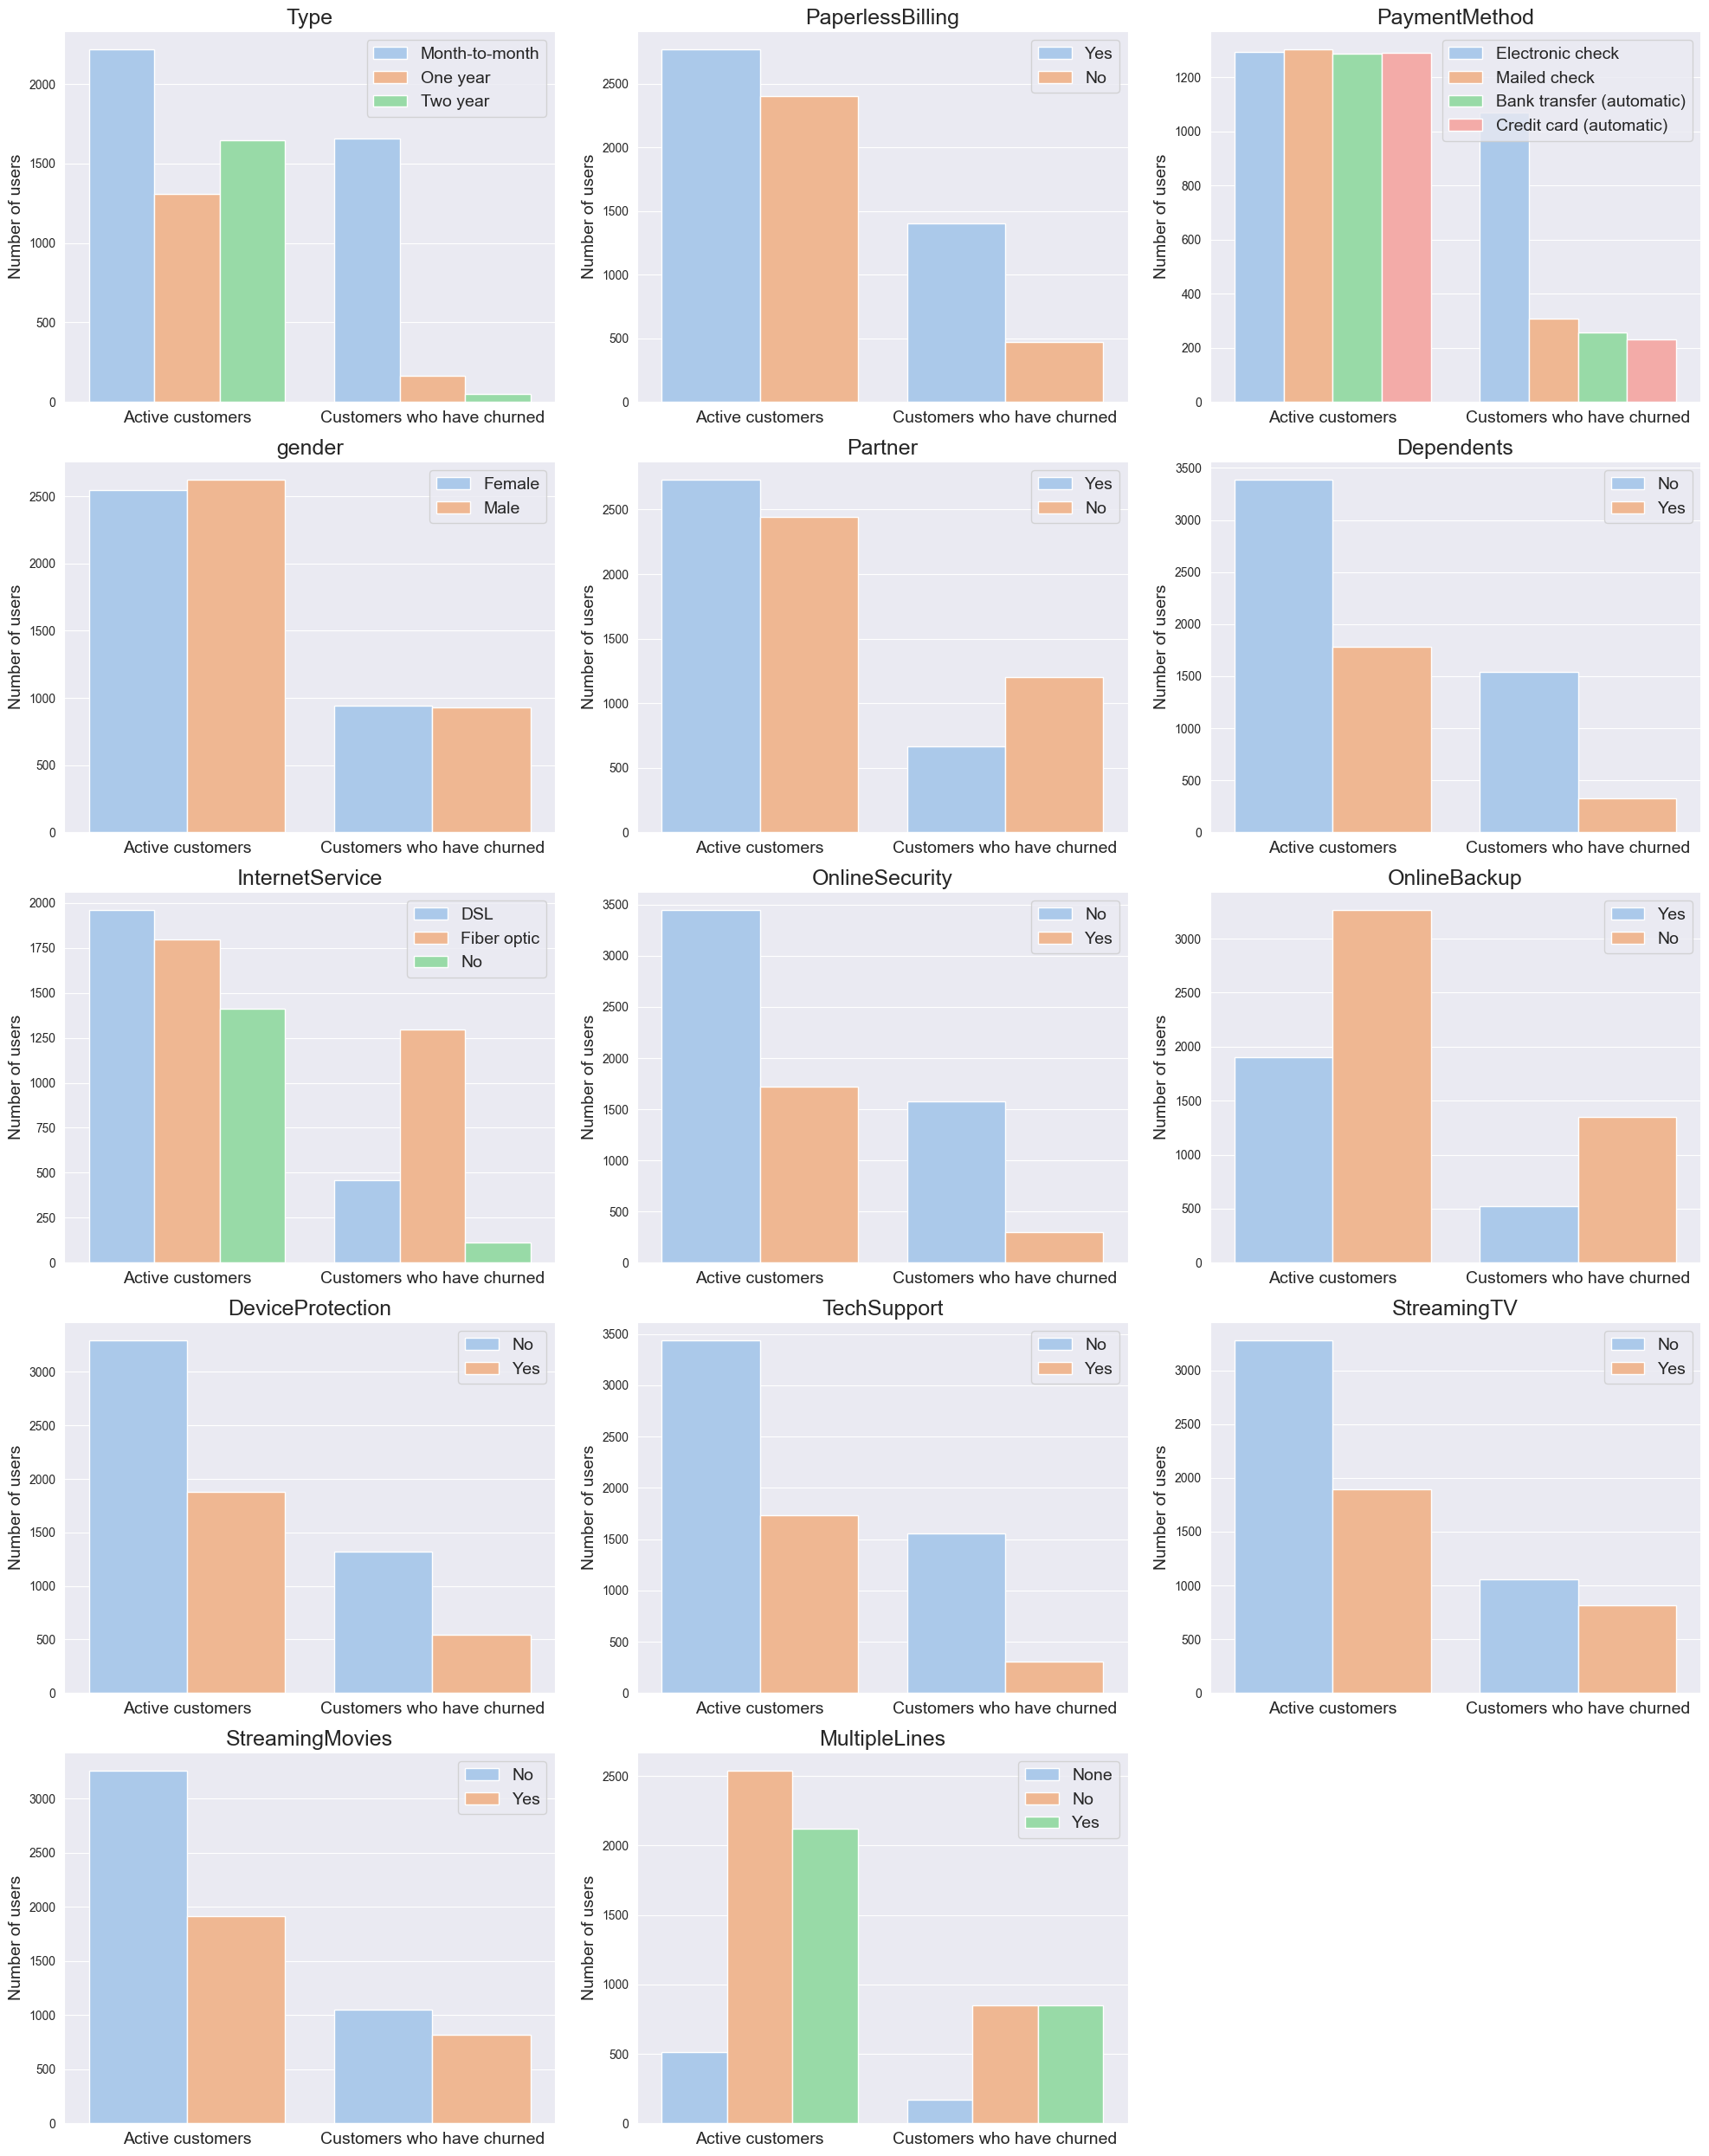

In [37]:
categorical = df_telecom.select_dtypes('object').columns
plt.figure(figsize=(20, 25))

for i, col in enumerate(categorical):
    ax = plt.subplot(5, 3, i+1)
    sns.countplot(data=df_telecom, x=df_telecom['CancelFactor'], hue=col, ax=ax, palette='pastel')
    ax.set_title(col, fontsize=18)
    ax.set_xticklabels(['Active customers', 'Customers who have churned'], fontsize=14)
    ax.set_ylabel('Number of users', fontsize=14)
    ax.set_xlabel('')
    ax.legend(fontsize=14, title_fontsize=14)
plt.tight_layout()

**Conclusion.**

* Among the customers who have churned the majority of them paid for the services on a monthly basis, indicating a higher probability of churn compared to customers with annual payment. The lowest churn probability is observed among customers who pay for services once every two years. Among active customers the highest number of customers has a monthly payment, followed by customers with payment once every two years, and then once a year.
* Among the churned customers the number of customers with paperless billing option is three times higher than those who requested the paper version.
* Customers who use electronic check payment method are more likely to churn.
* There is no significant influence of gender identity and the use of additional services such as `SteamingTV`, `StreamingMovies` and `MultipleLines`.
* Unmarried individuals without dependents are more likely to churn.
* The highest probability of churn is observed among customers using fiber optic internet, while the lowest is among customers who do not use the internet.
* The absence of additional services for network security, online backup, device protection, and technical support positively correlates with churn.

For numerical features:

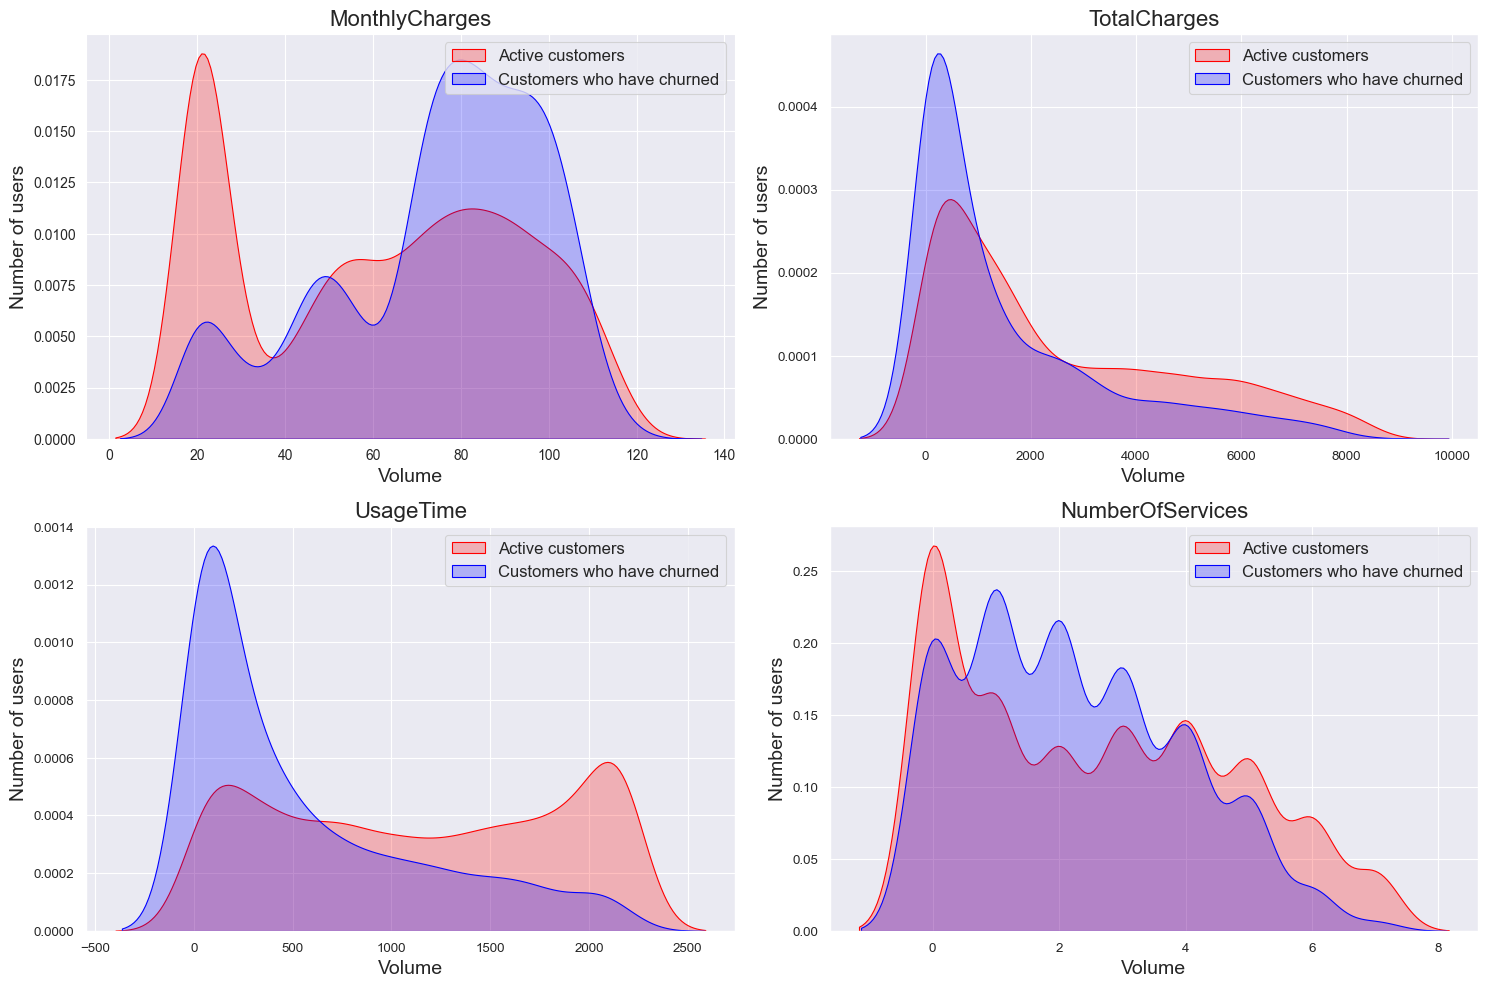

In [38]:
numeric = ['MonthlyCharges', 'TotalCharges', 'UsageTime', 'NumberOfServices']
plt.figure(figsize=(15, 10))

for i, col in enumerate(numeric):
    ax = plt.subplot(2, 2, i+1)
    sns.set_context("paper", font_scale=1.1)
    ax = sns.kdeplot(df_telecom[df_telecom['CancelFactor'] == 0][col], color="Red", shade=True)
    ax = sns.kdeplot(df_telecom[df_telecom['CancelFactor'] == 1][col], ax=ax, color="Blue", shade=True)
    ax.legend(['Active customers', 'Customers who have churned'], loc='upper right', fontsize=12)
    ax.set_ylabel('Number of users', fontsize=14)
    ax.set_xlabel('Volume', fontsize=14)
    ax.set_title(col, fontsize=16)
plt.tight_layout()

**Conclusion**.

* The higher the monthly payment amount for a customer, the higher the probability of churn. It can also be noted that active customers have a lower monthly payment amount compared to churned customers.
* Based on the graph of the total amount spent and the duration of service usage, customers are more likely to churn in the early stages of usage, and the probability of churn decreases over time.
* The fewer additional services are subscribed to, the higher the probability of churn.

### Checking for Multicollinearity

Considering that we are working with a dataset containing numerical and categorical features, let's examine the correlation between the features using the phik library. For easier analysis, we will use the plot_correlation_matrix function to visualize the results as a heatmap.

In [39]:
# obtaining the correlation matrix using the phik_matrix() method

phik_overview = df_telecom.phik_matrix()

interval columns not set, guessing: ['MonthlyCharges', 'TotalCharges', 'CancelFactor', 'SeniorCitizen', 'UsageTime', 'NumberOfServices']


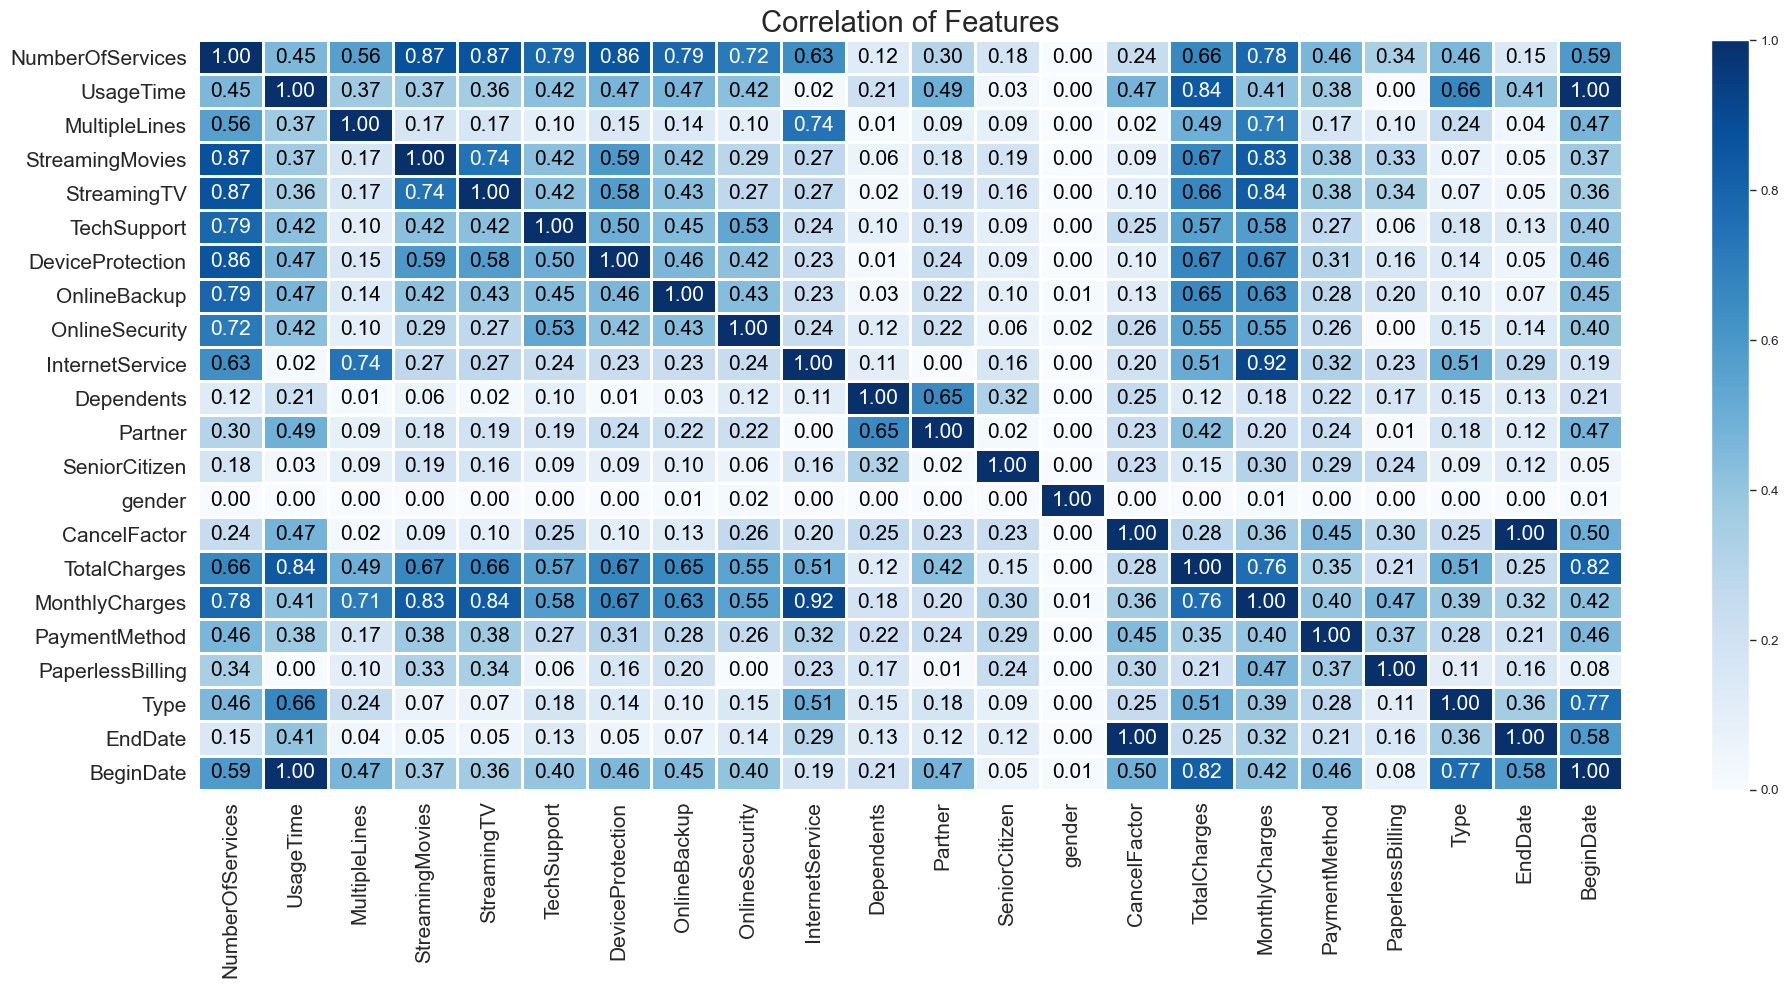

In [40]:
# displaying the results as a heatmap

plot_correlation_matrix(phik_overview.values, 
                        x_labels=phik_overview.columns, 
                        y_labels=phik_overview.index, 
                        vmin=0, vmax=1, color_map="Blues", 
                        title="Correlation of Features", 
                        fontsize_factor=1.5, 
                        figsize=(20, 10))
plt.tight_layout()

**Conclusion.**

* Based on the heatmap, there is a strong positive correlation between the count of additional services used (NumberOfServices) and the specific services themselves (StreamingTV, StreamingMovies, DeviceProtection), between the total amount spent on services (TotalCharges) and the usage time (UsageTime), as well as the contract start date (BeginDate). There is also a strong positive correlation between monthly payments and internet usage. Additionally, there are positive correlations between certain features (CancelFactor, UsageTime) and dates.

Next, I will analyze the numerical features (`MonthlyCharges`, `TotalCharges`, `UsageTime`, `NumberOfServices`) using the corr() method. Since the data distribution is non-normal, I will calculate the correlation using the Spearman method.

Extracting the numerical features:

In [41]:
numeric_corr = df_telecom[['MonthlyCharges', 'TotalCharges', 'UsageTime', 'NumberOfServices', 'CancelFactor']]

Displaying the correlation coefficients between them:

In [42]:
numeric_corr.corr(method='spearman')

,MonthlyCharges,TotalCharges,UsageTime,NumberOfServices,CancelFactor
MonthlyCharges,1.000000,0.638028,0.273912,0.792063,0.184743
TotalCharges,0.638028,1.000000,0.888753,0.761022,-0.229955
UsageTime,0.273912,0.888753,1.000000,0.510060,-0.375687
NumberOfServices,0.792063,0.761022,0.510060,1.000000,-0.046787
CancelFactor,0.184743,-0.229955,-0.375687,-0.046787,1.000000


Let's examine the correlation of numerical features separately for churned and active customers.

* For churned customers:

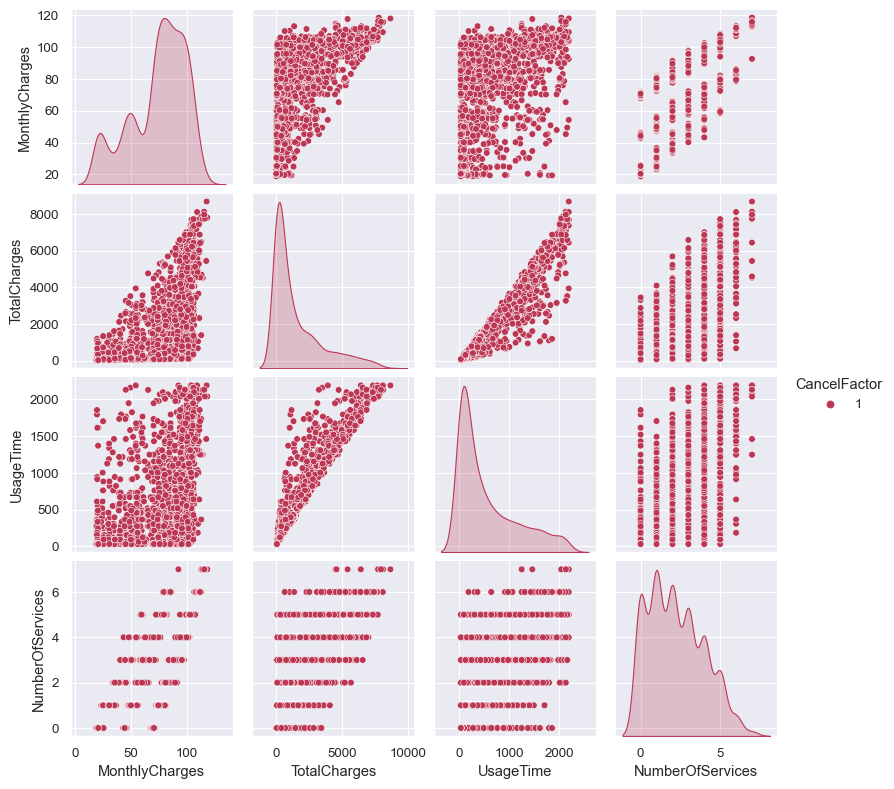

In [43]:
# using the pairplot() function to visualize the graph

_ = sns.pairplot(numeric_corr[numeric_corr['CancelFactor'] == 1], hue='CancelFactor', palette='inferno', height=2)

**Conclusion.** Among churned customers, there is a **very high** correlation between the `TotalCharges` and `UsageTime` features, and a **high** correlation between the `MonthlyCharges` and `NumberOfServices` factors, as well as `TotalCharges` and `MonthlyCharges`.

* For active customers:

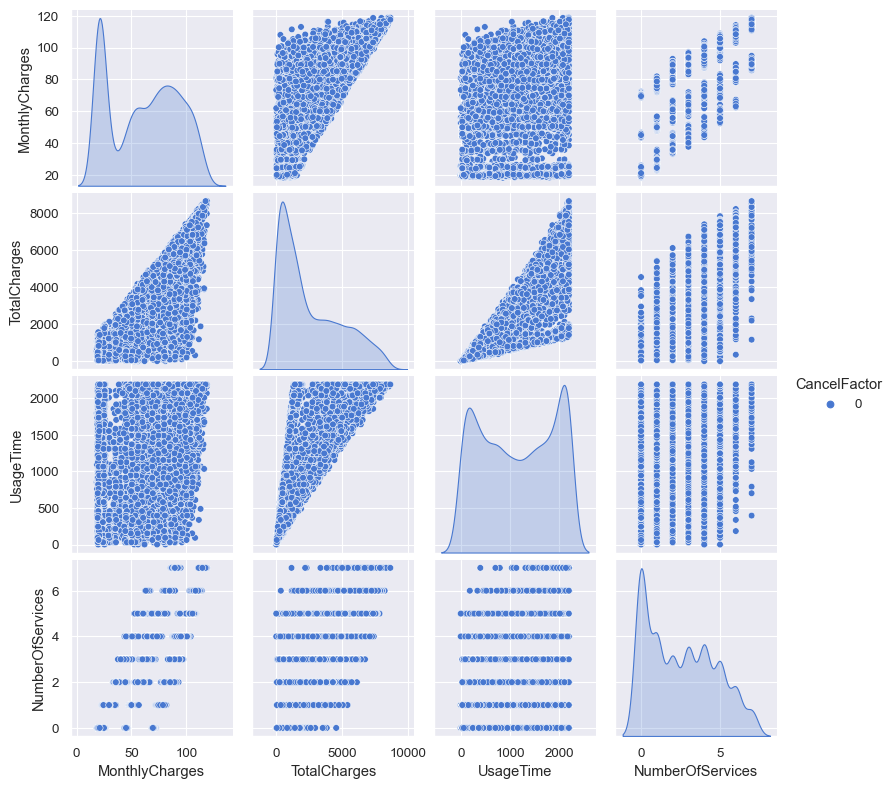

In [44]:
_ = sns.pairplot(numeric_corr[numeric_corr['CancelFactor'] == 0], hue='CancelFactor', palette='muted', height=2)

**Conclusion.** 
* Among active users, there is a **high** correlation between factors that characterize the total amount spent on services (`TotalCharges`) and the duration of service usage (`UsageTime`), as well as between the monthly payment amount (`MonthlyCharges`) and the number of subscribed services (`NumberOfServices`).

Based on the correlation analysis of numerical features, we can conclude that there is multicollinearity between the features **TotalCharges** and **UsageTime** (correlation coefficient = 0.9). To determine which feature to keep, we need to understand which one has a stronger impact on the target variable. To do this, I will plot box plots for each feature grouped by churn.

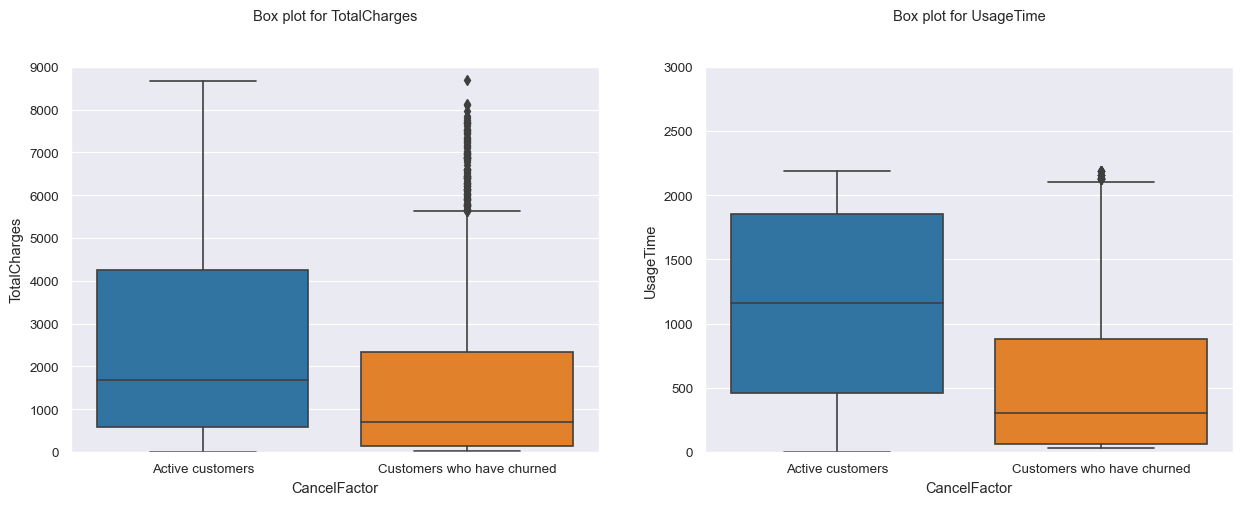

In [45]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

sns.boxplot(x="CancelFactor", y="TotalCharges", data=numeric_corr, ax=axes[0])
axes[0].set_ylim(0, 9000)
axes[0].set_title('Box plot for TotalCharges', y=1.1)
axes[0].set_xticklabels(['Active customers', 'Customers who have churned'])

sns.boxplot(x="CancelFactor", y="UsageTime", data=numeric_corr, ax=axes[1])
axes[1].set_ylim(0, 3000)
axes[1].set_title('Box plot for UsageTime', y=1.1)
axes[1].set_xticklabels(['Active customers', 'Customers who have churned'])

plt.show()

Based on the obtained box plots, a larger gap between the medians is observed for the UsageTime feature. Thus, we can assume that the UsageTime feature has a more significant influence on churn prediction than the TotalCharges feature. Additionally, to assess the data distribution, numerical summaries were generated bellow.

In [46]:
print('Numerical summary for churned customers:')
display(numeric_corr[numeric_corr['CancelFactor'] == 1].describe())
print('Numerical summary for active customers:')
numeric_corr[numeric_corr['CancelFactor'] == 0].describe()

Numerical summary for churned customers:


,MonthlyCharges,TotalCharges,UsageTime,NumberOfServices,CancelFactor
count,1869.000000,1869.000000,1869.000000,1869.000000,1869.0
mean,74.441332,1531.796094,547.352060,2.223114,1.0
std,24.666053,1890.822994,594.389607,1.704629,0.0
min,18.850000,18.850000,30.000000,0.000000,1.0
25%,56.150000,134.500000,61.000000,1.000000,1.0
50%,79.650000,703.550000,304.000000,2.000000,1.0
75%,94.200000,2331.300000,883.000000,3.000000,1.0
max,118.350000,8684.800000,2191.000000,7.000000,1.0


Numerical summary for active customers:


,MonthlyCharges,TotalCharges,UsageTime,NumberOfServices,CancelFactor
count,5174.000000,5174.000000,5174.000000,5174.000000,5174.0
mean,61.265124,2549.911442,1144.447236,2.545226,0.0
std,31.092648,2329.954215,733.897937,2.149223,0.0
min,18.250000,0.000000,0.000000,0.000000,0.0
25%,25.100000,572.900000,457.000000,0.000000,0.0
50%,64.425000,1679.525000,1157.000000,2.000000,0.0
75%,88.400000,4262.850000,1857.000000,4.000000,0.0
max,118.750000,8672.450000,2191.000000,7.000000,0.0


Analyzing the data characteristics, we can conclude that the difference between the medians for both TotalCharges and UsageTime is approximately the same for churned and active customers (976 and 853, respectively). However, considering that TotalCharges can be treated as a derivative of the MonthlyCharges and UsageTime features, a final decision can be made to remove TotalCharges from the dataset.

### Feature Selection

In addition to excluding the feature `TotalCharges` with high collinearity (0.9), I will also exclude the following factors: `BeginDate`, `EndDate`, `StreamingTV`, `StreamingMovies`, `DeviceProtection`, and `InternetService`. These features represent dates and information about subscribed services (which showed high correlation with other categorical features). Moreover, information about subscribed services is already captured in the `NumberOfServices` feature.

In [47]:
df_telecom_copy = df_telecom.drop(columns=['BeginDate', 'EndDate', 'StreamingTV', 'StreamingMovies', \
                                           'DeviceProtection', 'InternetService', 'TotalCharges'])

The features have been selected, and now we can proceed to the model exploration phase.

## Model Training

Creating variables for the features:

In [48]:
features = df_telecom_copy.drop(columns=['CancelFactor'])
target = df_telecom_copy['CancelFactor'] 

Performing class imbalance check:

0    0.73463
1    0.26537
Name: CancelFactor, dtype: float64


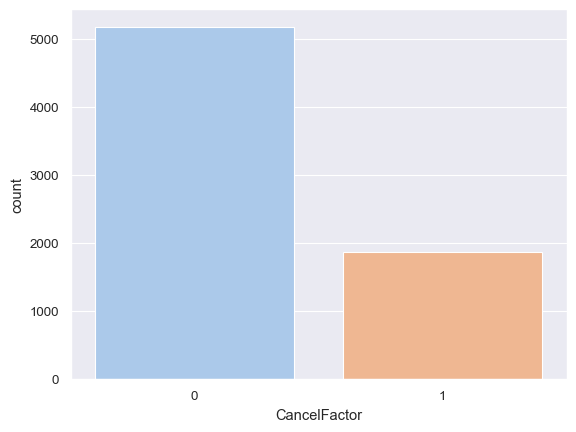

In [49]:
print(target.value_counts(normalize=True))
sns.countplot(data=df_phone, x=target, palette='pastel')
plt.show()

There is a significant class imbalance: the "0" class in the target feature occurs three times more frequently than the "1" class (in a ratio of 74:26%). I will take this imbalance into account when splitting the data into train and test sets (using the "stratify" argument) and during model training (using the "class_weights" attribute).

Splitting the dataset into training and test sets:

In [50]:
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.25, \
                                                                        random_state=RANDOM_STATE, stratify=target)
print(f"Number of instances in the target feature for each class in the training set: {np.bincount(target_train)}")
print(f"Number of instances in the target feature for each class in the test set: {np.bincount(target_test)}")

Number of instances in the target feature for each class in the training set: [3880 1402]
Number of instances in the target feature for each class in the test set: [1294  467]


We obtained two sets with 75% and 25% of the original dataset respectively, while preserving the initial class distribution - 74% of examples belong to class "0" and 26% of examples belong to class "1".

### Feature Scaling and Encoding

For feature encoding and scaling I will use a column_transformer:

In [51]:
numeric = features_train.select_dtypes(exclude='object').columns
categorical = features_train.select_dtypes(include=['object']).columns

col_transformer = ColumnTransformer(transformers=[
                                ('scaler', StandardScaler(), numeric),
                                ('ohe', OneHotEncoder(handle_unknown='ignore', sparse=False), categorical)],
                                remainder='passthrough')

features_train = pd.DataFrame(col_transformer.fit_transform(features_train), 
                              columns=col_transformer.get_feature_names_out())

features_test = pd.DataFrame(col_transformer.transform(features_test), 
                             columns=col_transformer.get_feature_names_out())

In [52]:
features_train.select_dtypes(exclude='object').columns

Index(['scaler__MonthlyCharges', 'scaler__SeniorCitizen', 'scaler__UsageTime',
       'scaler__NumberOfServices', 'ohe__Type_Month-to-month',
       'ohe__Type_One year', 'ohe__Type_Two year', 'ohe__PaperlessBilling_No',
       'ohe__PaperlessBilling_Yes',
       'ohe__PaymentMethod_Bank transfer (automatic)',
       'ohe__PaymentMethod_Credit card (automatic)',
       'ohe__PaymentMethod_Electronic check',
       'ohe__PaymentMethod_Mailed check', 'ohe__gender_Female',
       'ohe__gender_Male', 'ohe__Partner_No', 'ohe__Partner_Yes',
       'ohe__Dependents_No', 'ohe__Dependents_Yes', 'ohe__OnlineSecurity_No',
       'ohe__OnlineSecurity_Yes', 'ohe__OnlineBackup_No',
       'ohe__OnlineBackup_Yes', 'ohe__TechSupport_No', 'ohe__TechSupport_Yes',
       'ohe__MultipleLines_No', 'ohe__MultipleLines_None',
       'ohe__MultipleLines_Yes'],
      dtype='object')

Performing verification:

In [53]:
features_train.head()

,scaler__MonthlyCharges,scaler__SeniorCitizen,scaler__UsageTime,scaler__NumberOfServices,ohe__Type_Month-to-month,ohe__Type_One year,ohe__Type_Two year,ohe__PaperlessBilling_No,ohe__PaperlessBilling_Yes,ohe__PaymentMethod_Bank transfer (automatic),...,ohe__Dependents_Yes,ohe__OnlineSecurity_No,ohe__OnlineSecurity_Yes,ohe__OnlineBackup_No,ohe__OnlineBackup_Yes,ohe__TechSupport_No,ohe__TechSupport_Yes,ohe__MultipleLines_No,ohe__MultipleLines_None,ohe__MultipleLines_Yes
0,-1.487071,2.235053,-0.342643,-1.212881,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
1,0.967244,-0.447417,1.124125,0.753490,0.0,1.0,0.0,1.0,0.0,1.0,...,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0
2,-1.510335,-0.447417,-0.380115,-1.212881,0.0,0.0,1.0,1.0,0.0,0.0,...,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
3,1.286288,-0.447417,1.452007,1.245083,0.0,0.0,1.0,0.0,1.0,0.0,...,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
4,1.332815,-0.447417,0.515202,1.245083,1.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0


In [54]:
features_train.describe()

,scaler__MonthlyCharges,scaler__SeniorCitizen,scaler__UsageTime,scaler__NumberOfServices,ohe__Type_Month-to-month,ohe__Type_One year,ohe__Type_Two year,ohe__PaperlessBilling_No,ohe__PaperlessBilling_Yes,ohe__PaymentMethod_Bank transfer (automatic),...,ohe__Dependents_Yes,ohe__OnlineSecurity_No,ohe__OnlineSecurity_Yes,ohe__OnlineBackup_No,ohe__OnlineBackup_Yes,ohe__TechSupport_No,ohe__TechSupport_Yes,ohe__MultipleLines_No,ohe__MultipleLines_None,ohe__MultipleLines_Yes
count,5.282000e+03,5.282000e+03,5.282000e+03,5.282000e+03,5282.000000,5282.000000,5282.000000,5282.000000,5282.000000,5282.000000,...,5282.000000,5282.000000,5282.000000,5282.000000,5282.000000,5282.000000,5282.000000,5282.000000,5282.000000,5282.000000
mean,1.412476e-17,-3.363038e-17,9.080203e-17,2.085084e-17,0.553768,0.210716,0.235517,0.403635,0.596365,0.216017,...,0.298940,0.715070,0.284930,0.657705,0.342295,0.714313,0.285687,0.480500,0.095418,0.424082
std,1.000095e+00,1.000095e+00,1.000095e+00,1.000095e+00,0.497148,0.407855,0.424362,0.490672,0.490672,0.411565,...,0.457837,0.451424,0.451424,0.474523,0.474523,0.451784,0.451784,0.499667,0.293820,0.494250
min,-1.545230e+00,-4.474168e-01,-1.319596e+00,-1.212881e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-9.569924e-01,-4.474168e-01,-9.515658e-01,-7.212883e-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.804339e-01,-4.474168e-01,-1.378841e-01,-2.296954e-01,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,...,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
75%,8.309852e-01,-4.474168e-01,9.233816e-01,7.534903e-01,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000
max,1.784795e+00,2.235053e+00,1.612602e+00,2.228269e+00,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


The data has been transformed, and we can now proceed to the model training phase. For this project I will consider three models: logistic regression, random forest, and CatBoost.

### LogisticRegression

Creating a dictionary with model parameters:

In [55]:
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100]}

Next, I will train the model by tuning a hyperparameter and output the best value and the corresponding AUC-ROC metric.

In [56]:
model_logistic = LogisticRegression(class_weight='balanced', random_state=RANDOM_STATE)

grid = GridSearchCV(model_logistic, param_grid, scoring='roc_auc')

grid.fit(features_train, target_train)

predicted_probalities_log = grid.best_estimator_.predict_proba(features_train)[:, 1]

score_log = roc_auc_score(target_train, predicted_probalities_log)

print("AUC-ROC for logistic regression:", score_log)

AUC-ROC for logistic regression: 0.8463403716340426


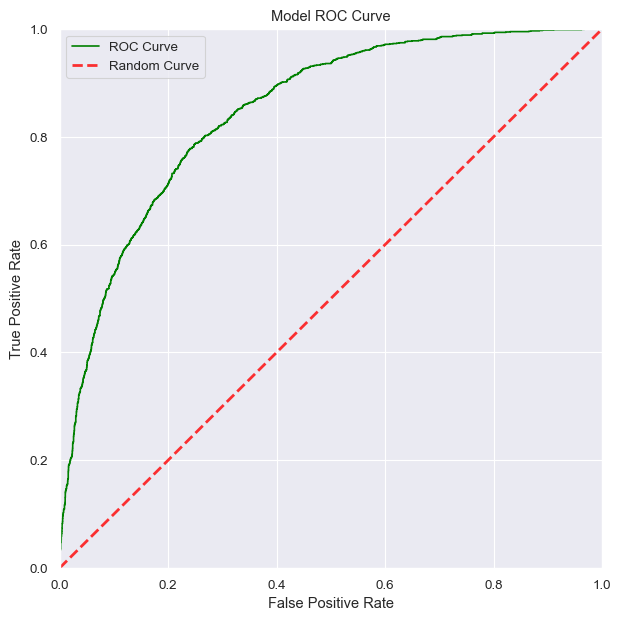

In [57]:
# Call the function to plot the ROC curve of the model

plot_roc_curve(target_train, predicted_probalities_log)

### RandomForestClassifier

In [58]:
# Creating a dictionary of model parameters

param_grid_forest = {
    'max_depth': [5, 20, 50],
    'min_samples_split': [2, 10],
    'n_estimators': [10, 50, 100], 
}

In [59]:
# Training the model, displaying the best hyperparameter values and the AUC-ROC score

model_forest = RandomForestClassifier(class_weight='balanced', random_state=RANDOM_STATE)

grid_forest = GridSearchCV(model_forest, param_grid_forest, scoring='roc_auc')

grid_forest.fit(features_train, target_train)

predicted_probalities_forest = grid_forest.best_estimator_.predict_proba(features_train)[:, 1]

score_forest = roc_auc_score(target_train, predicted_probalities_forest)

print("AUC-ROC for random forest:", score_forest)

AUC-ROC for random forest: 0.8581444769622188


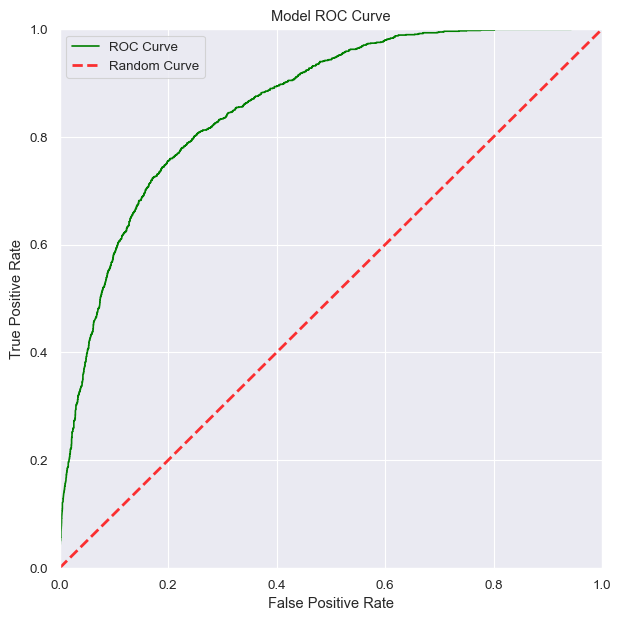

In [60]:
# Call the function to plot the ROC curve of the model

plot_roc_curve(target_train, predicted_probalities_forest)

### CatBoostClassifier

In [61]:
# Creating a dictionary of model parameters

param_grid_cat = {
    'learning_rate': [0.01, 0.1, 0.5],
    'iterations': [50, 100, 200],
    'depth': [3, 5, 7, 9]
}

For the CatBoostClassifier model I will create a `class_weights` dictionary with the classes and their corresponding weights, computed considering the class imbalance, and pass it as a parameter to the model.

In [62]:
classes = np.unique(target_train)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=target_train)
class_weights = dict(zip(classes, weights))

print(class_weights)

{0: 0.6806701030927835, 1: 1.883737517831669}


In [63]:
# Training the model, displaying the best hyperparameter values and the AUC-ROC score

model_cat = CatBoostClassifier(class_weights=class_weights, random_state=RANDOM_STATE, verbose=0)

grid_cat = GridSearchCV(model_cat, param_grid_cat, scoring='roc_auc')

grid_cat.fit(features_train, target_train)

predicted_probalities_cat = grid_cat.best_estimator_.predict_proba(features_train)[:, 1]

score_cat = roc_auc_score(target_train, predicted_probalities_cat)

print("AUC-ROC:", score_cat)

AUC-ROC: 0.9772248224186362


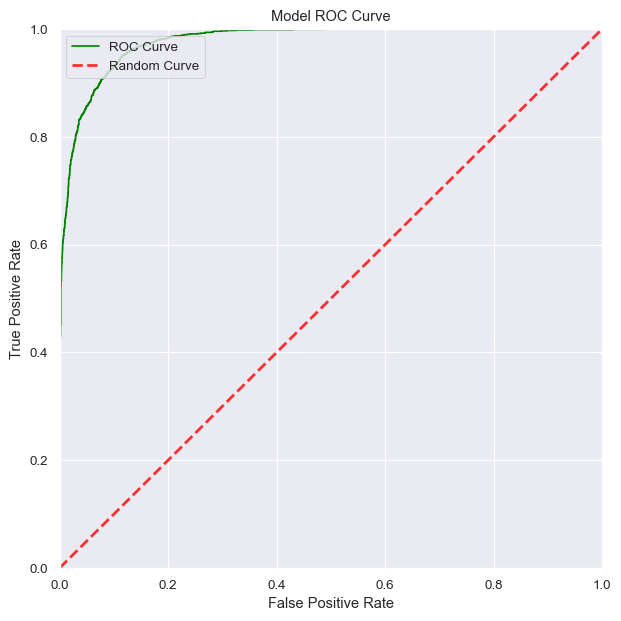

In [64]:
plot_roc_curve(target_train, predicted_probalities_cat)

## Model Analysis

In [65]:
# Use pd.set_option to display the entire text in the cell

pd.set_option('display.max_colwidth', None)

# Pass the performance indicators' values to the DataFrame constructor

results = pd.DataFrame(
    {'Model params' : [grid.best_params_, grid_forest.best_params_, grid_cat.best_params_],
    'Prediction Quality (AUC-ROC)' : [score_log, score_forest, score_cat]})
results.index = ['LogisticRegression', 'RandomForestClassifier', 'CatBoost']
display(results)

,Model params,Prediction Quality (AUC-ROC)
LogisticRegression,{'C': 1},0.846340
RandomForestClassifier,"{'max_depth': 5, 'min_samples_split': 2, 'n_estimators': 50}",0.858144
CatBoost,"{'depth': 3, 'iterations': 200, 'learning_rate': 0.5}",0.977225


**Conclusion:**
* The CatBoostClassifier model performed the best with an AUC-ROC metric value of 0.98.

## Testing the Best Model

In [66]:
# Displaying the AUC-ROC score

print("AUC-ROC:", roc_auc_score(target_test, grid_cat.predict_proba(features_test)[:, 1]))

AUC-ROC: 0.928109972232243


The model generalizes well to new data as it performs well on the test set.

### Model Evaluation using Additional Metrics

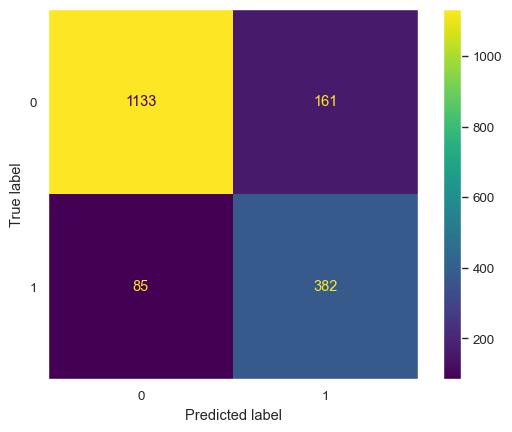

In [67]:
# Making predictions on the test dataset

y_pred = grid_cat.predict(features_test)

# Computing the confusion matrix

cm = confusion_matrix(target_test, y_pred)

# Creating a ConfusionMatrixDisplay object and displaying the confusion matrix

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.grid(False)
plt.show()

In [68]:
# Calculating precision

print("Model Precision:", precision_score(target_test, y_pred))

# Calculating recall using the recall_score() function

print("Model Recall:", recall_score(target_test, y_pred))

Model Precision: 0.7034990791896869
Model Recall: 0.8179871520342612


**Conclusion.**

* The model correctly classified 1,144 and 379 instances for the first and second classes respectively, and misclassified 150 instances of the first class as the second class and 88 instances of the second class as the first class.
* The precision of the model is 0.72, indicating that 72% of the instances were correctly classified.
* The recall for the second class is 0.81, meaning that the model was able to correctly identify 81% of all instances of the second class.

Overall, the model has reasonably high precision and recall.

## Feature Importance Determination

In [69]:
# Displaying feature importance information in tabular form

feature_importances = pd.DataFrame(grid_cat.best_estimator_.feature_importances_,
                                   index = features_train.columns,
                                   columns=['Importances']).sort_values(by='Importances', ascending=False)
display(feature_importances)

,Importances
scaler__UsageTime,71.330052
scaler__MonthlyCharges,13.031201
ohe__Type_Month-to-month,2.962886
scaler__NumberOfServices,2.037434
ohe__PaymentMethod_Electronic check,1.656765
ohe__Type_Two year,1.404976
ohe__PaymentMethod_Mailed check,1.390094
ohe__Type_One year,0.666588
ohe__TechSupport_Yes,0.595791
ohe__OnlineSecurity_No,0.468607


**Conclusion.**

* Overall, the results indicate that the `UsageTime` feature (duration of service usage) is the most important for predicting the target feature in this dataset, followed by the `MonthlyCharges` (monthly payments) and `Type_Month-to-mont` (month-to-month payment type) features. These results can be used to justify feature selection or further development in future iterations of the model.

# Report

# Introduction

As individual studies show, the majority of customers do not remain loyal to one brand but seek alternatives. According to data from public sources, over 50% of telecommunications operator customers have switched to new providers in search of better conditions and service.

The telecommunication provider wants to learn to predict customer churn. If it turns out that a user plans to leave, they will be offered promotional codes and special conditions. The provider's team has collected personal data about some customers, as well as information about their tariffs and contracts.

Our **objective** was to analyze this data, study customer behavior, identify relationships and patterns to better understand their needs. The data analysis and customer churn prediction model project will help the telecommunication provider understand the factors influencing customer attrition and how to retain them, as well as improve the quality of their services.

The project **goal** is to build a model to predict the likelihood of customer churn. The evaluation criterion for the model's quality will be the MAE metric, and the AUC-ROC value should be at least 0.88.

This report includes the results of the customer data analysis, covering the data preparation process, model building and evaluation for predicting the probability of customer churn, as well as the description of model results and recommendations for the telecommunication provider based on the obtained results.

# Methodology

The following work was conducted during the research.

✔️  **Data exploration:** providing general information about the datasets, descriptive statistics, visualization of feature distributions, and conclusions.

✔️ Creation of a **work plan.**

✔️ **Data preprocessing:** converting the data types of BeginDate, EndDate, and TotalCharges to the correct format, handling missing values, merging datasets, checking for duplicates, and creating synthetic features.

✔️  **Data analysis:** conducting data analysis to understand the factors that may influence customer churn, including the construction of graphs and charts. Checking for multicollinearity among features and correlation with the target variable.

✔️ **Data preparation** for training: scaling and encoding the data.

✔️ **Model building and evaluation:** based on the data analysis, it was necessary to build a model to predict the probability of customer churn. Machine learning algorithms such as logistic regression, random forest, or gradient boosting were used for this purpose. After building the model, its quality was evaluated using the AUC-ROC metric. The best model was selected.

✔️ **Model testing:** assessing the quality of the best model on the test dataset, displaying the confusion matrix, and determining additional metrics such as recall and precision on the test set.

✔️ Analysis of **feature importance** in the selected model.

# Results

Based on the preliminary analysis of the data, the following customer profile was identified:

* Most customers pay for services on a monthly basis and use paperless billing option. The most popular payment method is electronic checks.
* There are five times more customers below the retirement age compared to retirees. The number of male and female customers is approximately equal. The majority of users are unmarried and do not have dependents.
* Customers with fiber optic internet connections are the largest group.
* Additional services such as internet security (antivirus and blocking unsafe websites), dedicated technical support line, cloud storage for data backup, streaming TV, and movie catalog are generally not popular among customers.
* Most people do not use multiple line connections for telephone devices simultaneously.

***

📋 All planned steps have been completed:


`*` Three features were created: `CancelFactor` (the target feature), `UsageTime`, `NumberOfServices`.

`*` Based on the **correlation analysis** between the features, the following findings were made: 
* among users who churned, the majority paid for services monthly, 
* the higher the monthly payment amount for a customer, the higher the likelihood of churn, 
* customers are more likely to churn in the early stages of service usage, and the likelihood decreases over time, * the fewer additional services are subscribed, the higher the likelihood of customer churn.

Based on the correlation analysis between numerical features, it was concluded that there is multicollinearity between the TotalCharges and UsageTime factors (correlation coefficient: 0.9). An evaluation of the impact of these features on the target was conducted to determine which factor to keep. The choice was made in favor of UsageTime.

`*` **Feature selection:** The TotalCharges feature, as well as the BeginDate, EndDate, StreamingTV, StreamingMovies, DeviceProtection, and InternetService factors were excluded from the dataset. These features represent dates and information about subscribed services (they exhibited high correlation with other categorical features, and information about subscribed services is captured in NumberOfServices).

`*` The final list of features used for model training:

In [70]:
df_telecom_copy.columns.to_list()

['Type',
 'PaperlessBilling',
 'PaymentMethod',
 'MonthlyCharges',
 'CancelFactor',
 'gender',
 'SeniorCitizen',
 'Partner',
 'Dependents',
 'OnlineSecurity',
 'OnlineBackup',
 'TechSupport',
 'MultipleLines',
 'UsageTime',
 'NumberOfServices']

`*` Model Training Results:

In [71]:
results

,Model params,Prediction Quality (AUC-ROC)
LogisticRegression,{'C': 1},0.846340
RandomForestClassifier,"{'max_depth': 5, 'min_samples_split': 2, 'n_estimators': 50}",0.858144
CatBoost,"{'depth': 3, 'iterations': 200, 'learning_rate': 0.5}",0.977225


The **CatBoostClassifier** model demonstrated **the best performance** with an ROC-AUC metric value of 0.98. The model correctly classified 1144 and 379 observations for the first and second classes respectively and misclassified 150 observations of the first class as the second class and 88 observations of the second class as the first class. The precision of the model is 0.72, indicating that 72% of the observations were correctly classified.
The recall for the second class is 0.81, meaning that the model was able to correctly identify 81% of all observations for the second class.

`*` Feature Importance Evaluation Results:

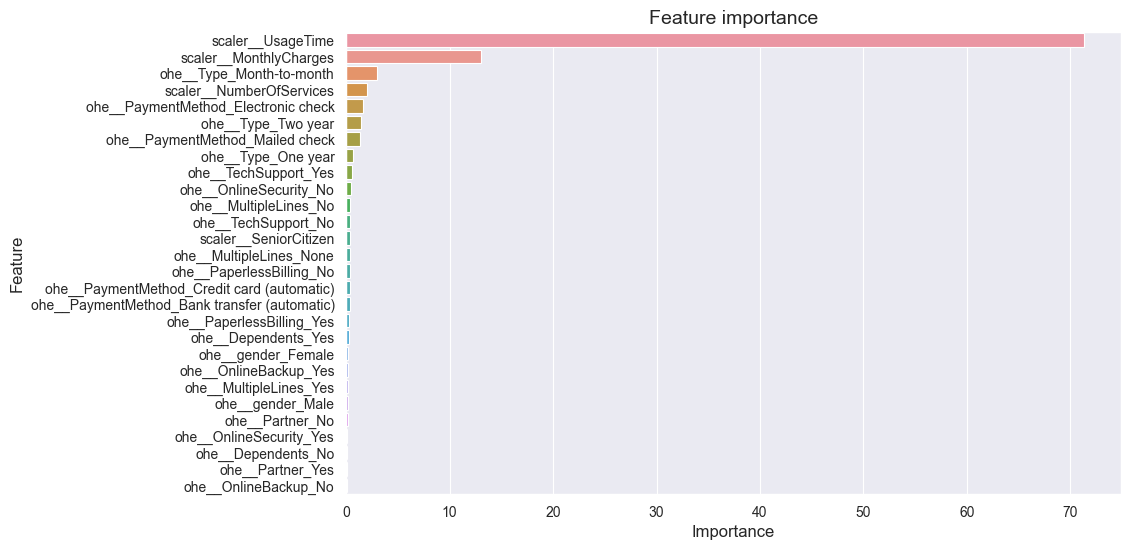

In [72]:
# Displaying feature importance information graphically

plt.figure(figsize=(10, 6))
sns.barplot(x='Importances', y=feature_importances.index, data=feature_importances)
plt.title('Feature importance', fontsize=14)
plt.xlabel('Importance', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()

The UsageTime feature (duration of service usage) is the most important feature for predicting the target variable in this dataset, followed by the MonthlyCharges (monthly payments) and Type_Month-to-month (month-to-month payment type) features. These results can be used to justify the selection or development of features in future iterations of the model.

# Conclusion

💡 Based on the obtained results the following actions can be recommended to improve the model and its results:

* Perform hyperparameter optimization for the CatBoostClassifier model to further improve its performance.
* Investigate the impact of additional features that were not considered in this stage on the model.
* Apply the obtained model to predict customer churn based on current data.

📞 **The research will enable the telecommunication provider to:**

* Predict the likelihood of customer churn based on their behavior data. This will help identify the most vulnerable customer groups and react in a timely manner to potential churn.
* Develop effective customer retention strategies tailored to specific user groups. For example, special promotions and loyal conditions can be offered to customers at high risk of churn.
* Optimize business processes and reduce operational costs by identifying the most efficient tools for customer management.
* Increase business revenue by reducing churn among high-value customers and attracting new users.